## Group No : 47
-----
## Group Member Names:
* VENKATESH SABINKAR (2023aa05510) - 100% Contribution
* BATTULA ESWARA RAO (2024ac05699) - 100% Contribution
* CHOCALINGAM L (2024ab05275) - 100% Contribution
* DEVENDRAPRATAP SINGH (2024ab05273) - 100% Contribution
* DURGA PRASAD YADAV (2024ab05147@wilp) - 100% Contribution

## Objective of the Assignment:
----
Implement and compare four generative modeling approaches for
face modification and synthesis:
1. Variational Autoencoder (VAE)
2. β-Variational Autoencoder (β-VAE)
3. Vector Quantized VAE (VQ-VAE) with PixelCNN prior for latent sampling
4. Generative Adversarial Network (GAN)
The goal is to understand how different latent representations influence reconstruction
quality, attribute manipulation, and sample realism in face images. Use provisioned WILP
lab infrastructure!

In [33]:
########################################################################
# Importing standard Python and PyTorch libraries
########################################################################

import os  # For interacting with the operating system (e.g., file paths)
import torch  # Core PyTorch library
import torch.nn as nn  # Neural network module in PyTorch
import torch.optim as optim  # Optimizers like SGD, Adam, etc.
from torch.utils.data import DataLoader  # For batching and loading datasets
from torchvision import datasets, transforms, utils  # Datasets and image transformations
from torchvision.utils import save_image, make_grid  # Utilities for saving and visualizing images
import matplotlib.pyplot as plt  # Plotting library for visualizations
import numpy as np  # Numerical computations, arrays, etc.
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict

In [34]:
########################################################################
# Set the device for computations: GPU if available, else CPU
########################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)  # Print which device is being used

Using device: cuda


In [57]:
# Directory where the CelebA images are stored
DATA_DIR = "data/img_align_celeba"

# Desired image size (images will be resized to 64x64)
IMAGE_SIZE = 64

# Batch size for training (number of images per batch)
BATCH_SIZE = 128

LATENT_DIM = 128
CODEBOOK_SIZE = 256
COMMITMENT_BETA = 0.25

EPOCHS_VQVAE = 40
EPOCHS_PIXELCNN = 30

SAVE_DIR = "./vqvae_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# ===========================================================
# Unified Metrics Storage (VAE + β-VAE + VQ-VAE + GAN)
# ===========================================================
# Central metrics registry
metrics = defaultdict(dict)

metrics = {
    # ------------------ Vanilla VAE ------------------
    "VAE": {
        "recon_loss": [],
        "kl_loss": [],
        "elbo": [],
        "recon_mse": []
    },

    # ------------------ β-VAE ------------------
    "BetaVAE": {
        2: {"recon_loss": [], "kl_loss": [], "elbo": [], "recon_mse": []},
        4: {"recon_loss": [], "kl_loss": [], "elbo": [], "recon_mse": []},
        10: {"recon_loss": [], "kl_loss": [], "elbo": [], "recon_mse": []}
    },

    # ------------------ VQ-VAE ------------------
    "VQVAE": {
        "recon_loss": [],          # Reconstruction loss (MSE / BCE)
        "vq_loss": [],             # Vector quantization loss
        "commitment_loss": [],     # Commitment loss (β ||sg[z_e] - e||²)
        "total_loss": [],          # recon + vq + commitment
        "perplexity": []           # Codebook usage metric
    },

    # ------------------ GAN ------------------
    "GAN": {
        "generator_loss": [],
        "discriminator_loss": [],
        "d_real": [],              # D(x)
        "d_fake": [],              # D(G(z))
        "fid": []                  # Optional
    }
}

########################################################################
# Define the image transformations to apply to each image
########################################################################
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors (values in [0,1])
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1] for each RGB channel
])

########################################################################
# Load the dataset from the directory, applying the transformations
# os.path.dirname(DATA_DIR) is used to get the parent folder of DATA_DIR
########################################################################
dataset = datasets.ImageFolder(root=os.path.dirname(DATA_DIR), transform=transform)

########################################################################
# Wrap the dataset in a DataLoader for batching, shuffling, and parallel loading
########################################################################
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,  # Number of images per batch
    shuffle=True,           # Shuffle dataset every epoch for better training
    num_workers=4           # Number of subprocesses to use for data loading
)

## Part A: Variational Autoencoder (VAE) [2 Marks]
---
## Tasks
1. Train the VAE
2. Visualize reconstructions
3. Perform latent interpolation between two faces
4. Perform attribute modification by vector arithmetic

In [36]:
# Dimension of the latent space (size of the vector representing each image)
LATENT_DIM = 128

########################################################################
# Define the Variational Autoencoder (VAE) model
########################################################################
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # ========================
        # Encoder: maps image → latent space
        # ========================
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),    # Conv layer: input 3 channels (RGB), output 32, kernel 4x4, stride 2, padding 1
                                            # Reduces spatial size: 64x64 → 32x32
            nn.ReLU(),                     # Non-linear activation
            nn.Conv2d(32, 64, 4, 2, 1),   # 32x32 → 16x16, feature maps 64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 → 8x8, feature maps 128
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8x8 → 4x4, feature maps 256
            nn.ReLU()
        )

        # Fully connected layers to get mean and log-variance for latent distribution
        self.fc_mu = nn.Linear(256 * 4 * 4, LATENT_DIM)       # μ: mean vector of latent space
        self.fc_logvar = nn.Linear(256 * 4 * 4, LATENT_DIM)   # log(σ²): log-variance vector

        # ========================
        # Decoder: maps latent vector → reconstructed image
        # ========================
        self.fc_dec = nn.Linear(LATENT_DIM, 256 * 4 * 4)      # Map latent vector back to 4x4x256 feature map

        # Upsampling through transposed convolutions to reconstruct image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4x4 → 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # 32x32 → 64x64, 3 channels (RGB)
            nn.Tanh()                                # Output in [-1, 1] to match normalized input
        )

    # ========================
    # Reparameterization trick
    # ========================
    def reparameterize(self, mu, logvar):
        """
        Samples from N(mu, sigma^2) using the reparameterization trick:
        z = mu + sigma * epsilon, where epsilon ~ N(0,1)
        This allows backpropagation through stochastic sampling.
        """
        std = torch.exp(0.5 * logvar)       # Compute standard deviation from log-variance
        eps = torch.randn_like(std)         # Sample epsilon from standard normal
        return mu + eps * std               # Return sampled latent vector z

    # ========================
    # Forward pass
    # ========================
    def forward(self, x):
        enc = self.encoder(x).view(x.size(0), -1)   # Encode and flatten to vector
        mu, logvar = self.fc_mu(enc), self.fc_logvar(enc)  # Get mean and logvar
        z = self.reparameterize(mu, logvar)        # Sample latent vector
        dec = self.fc_dec(z).view(-1, 256, 4, 4)   # Map latent vector to 4x4x256 feature map
        return self.decoder(dec), mu, logvar       # Decode to image + return μ and logvar for loss computation


In [37]:
def vae_loss(recon, x, mu, logvar):
    """
    Computes the Variational Autoencoder (VAE) loss and its components.

    VAE optimizes the Evidence Lower Bound (ELBO):
        ELBO = Reconstruction Loss + KL Divergence

    Parameters:
    ----------
    recon : torch.Tensor
        Reconstructed images produced by the decoder
    x : torch.Tensor
        Original input images
    mu : torch.Tensor
        Mean of the latent Gaussian distribution q(z|x)
    logvar : torch.Tensor
        Log-variance of the latent Gaussian distribution q(z|x)

    Returns:
    -------
    recon_loss : torch.Tensor
        Reconstruction loss (data fidelity term)
    kl_loss : torch.Tensor
        KL divergence (latent regularization term)
    elbo : torch.Tensor
        Total VAE loss (objective optimized during training)
    """

    # -------------------------------------------------
    # Reconstruction Loss
    # -------------------------------------------------
    # Measures how accurately the decoder reconstructs the input
    # Mean Squared Error (MSE) corresponds to assuming
    # a Gaussian likelihood p(x|z)
    # reduction='sum' sums over all pixels and batch samples,
    # matching the theoretical ELBO formulation
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')

    # -------------------------------------------------
    # KL Divergence Loss
    # -------------------------------------------------
    # Measures how far the learned posterior q(z|x) deviates
    # from the prior p(z) = N(0, I)
    #
    # Closed-form KL divergence between two Gaussians:
    # D_KL(q(z|x) || p(z)) =
    #   -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #
    # This term enforces a smooth, continuous latent space
    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    # -------------------------------------------------
    # ELBO (Total VAE Loss)
    # -------------------------------------------------
    # Combines reconstruction accuracy and latent regularization
    elbo = recon_loss + kl_loss

    return recon_loss, kl_loss, elbo


In [38]:
# =========================
# Initialize model, optimizer, and training parameters
# =========================

# Instantiate the Variational Autoencoder model
# The model consists of:
#  - Encoder: maps input image → latent distribution (μ, logσ²)
#  - Reparameterization trick: enables backpropagation through sampling
#  - Decoder: reconstructs image from sampled latent vector
model = VAE().to(device)

# Adam optimizer is chosen for its adaptive learning rate
# which helps stabilize training when optimizing KL divergence
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of training epochs
# VAEs typically require more epochs for the latent space to stabilize
EPOCHS = 100


# =========================
# Metric containers for analysis and comparison
# =========================
# These metrics will later be used for:
# - plotting training curves
# - comparing with β-VAE, VQ-VAE, and GAN
metrics = {
    "VAE": {
        "recon_loss": [],   # Pixel-level reconstruction quality
        "kl_loss": [],      # Latent regularization strength
        "elbo": []          # Total VAE objective (ELBO)
    }
}

# =========================
# Training loop
# =========================
for epoch in range(EPOCHS):

    # Set model to training mode
    # Enables layers like dropout/batchnorm (if present)
    model.train()

    # Accumulators for epoch-level metrics
    total_recon = 0.0   # Sum of reconstruction losses
    total_kl = 0.0      # Sum of KL divergences
    total_elbo = 0.0    # Sum of total losses
    num_samples = 0     # Number of processed images

    # Iterate over mini-batches
    for imgs, _ in dataloader:

        # Move input images to GPU (if available)
        imgs = imgs.to(device)

        # Clear gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass through VAE
        # recon  : reconstructed image
        # mu     : mean of latent distribution q(z|x)
        # logvar : log variance of latent distribution q(z|x)
        recon, mu, logvar = model(imgs)

        # Compute VAE loss components
        # recon_loss : reconstruction error (data fidelity)
        # kl_loss    : KL divergence between q(z|x) and N(0, I)
        # elbo       : total loss = recon_loss + kl_loss
        recon_loss, kl_loss, elbo = vae_loss(recon, imgs, mu, logvar)

        # Backpropagation through the stochastic graph
        # The reparameterization trick allows gradients to flow
        elbo.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate losses for epoch-level statistics
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        total_elbo += elbo.item()
        num_samples += imgs.size(0)

    # =========================
    # Normalize metrics per image
    # =========================
    # Normalization allows fair comparison across epochs and models
    avg_recon = total_recon / num_samples
    avg_kl = total_kl / num_samples
    avg_elbo = total_elbo / num_samples

    # Store metrics for later visualization and comparison
    metrics["VAE"]["recon_loss"].append(avg_recon)
    metrics["VAE"]["kl_loss"].append(avg_kl)
    metrics["VAE"]["elbo"].append(avg_elbo)

    # =========================
    # One-line epoch summary
    # =========================
    # Displays how reconstruction quality and latent regularization evolve
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Recon Loss: {avg_recon:.4f} | "
        f"KL Loss: {avg_kl:.4f} | "
        f"ELBO: {avg_elbo:.4f}"
    )


Epoch [1/100] | Recon Loss: 1869.1017 | KL Loss: 84.6627 | ELBO: 1953.7644
Epoch [2/100] | Recon Loss: 806.9312 | KL Loss: 122.5119 | ELBO: 929.4431
Epoch [3/100] | Recon Loss: 624.0931 | KL Loss: 126.6158 | ELBO: 750.7089
Epoch [4/100] | Recon Loss: 552.7679 | KL Loss: 127.1264 | ELBO: 679.8943
Epoch [5/100] | Recon Loss: 508.0894 | KL Loss: 128.0547 | ELBO: 636.1441
Epoch [6/100] | Recon Loss: 473.3659 | KL Loss: 129.0124 | ELBO: 602.3783
Epoch [7/100] | Recon Loss: 448.7576 | KL Loss: 130.0012 | ELBO: 578.7587
Epoch [8/100] | Recon Loss: 433.0397 | KL Loss: 130.9916 | ELBO: 564.0313
Epoch [9/100] | Recon Loss: 418.2548 | KL Loss: 131.9088 | ELBO: 550.1636
Epoch [10/100] | Recon Loss: 406.1522 | KL Loss: 132.7937 | ELBO: 538.9459
Epoch [11/100] | Recon Loss: 396.7663 | KL Loss: 133.6636 | ELBO: 530.4298
Epoch [12/100] | Recon Loss: 387.7439 | KL Loss: 134.3674 | ELBO: 522.1113
Epoch [13/100] | Recon Loss: 382.1595 | KL Loss: 135.0387 | ELBO: 517.1982
Epoch [14/100] | Recon Loss: 375.

              VAE Evaluation Report
Batch size                : 128
Image resolution          : 64 x 64
Channels                  : 3
Latent dimension          : 128
------------------------------------------------
Reconstruction Loss (Σ)   : 34869.46
KL Divergence             : 18160.08
ELBO                      : 53029.55
Mean Reconstruction MSE   : 0.022169
Assessment                : Good reconstructions with mild VAE-induced smoothing.



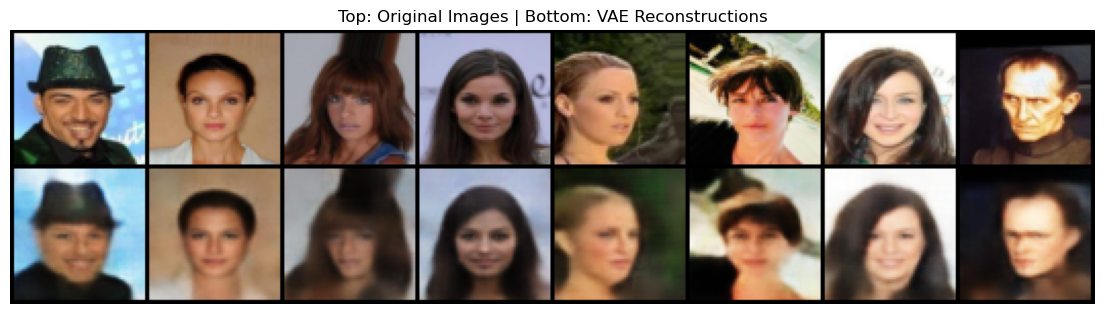

============ VAE Final Metrics ============
Reconstruction Loss : 34869.46
KL Divergence       : 18160.08
ELBO                : 53029.55
Reconstruction MSE  : 0.022169


In [41]:
def evaluate_vae(model, dataloader, device, metrics, num_display=8):
    """
    Evaluates a trained VAE model and collects metrics.

    Parameters
    ----------
    model       : trained VAE model
    dataloader  : evaluation dataloader
    device      : cpu / cuda
    metrics     : dictionary to store results
    num_display : number of images to visualize
    """

    # --------------------------------------------------
    # STEP 1: Evaluation mode
    # --------------------------------------------------
    # Ensures deterministic behavior
    model.eval()

    # --------------------------------------------------
    # STEP 2: Disable gradients
    # --------------------------------------------------
    with torch.no_grad():

        # --------------------------------------------------
        # STEP 3: Fetch one evaluation batch
        # --------------------------------------------------
        imgs, _ = next(iter(dataloader))
        imgs = imgs.to(device)

        # --------------------------------------------------
        # STEP 4: Forward pass
        # --------------------------------------------------
        recon, mu, logvar = model(imgs)

        # --------------------------------------------------
        # STEP 5: Compute VAE losses
        # --------------------------------------------------
        recon_loss, kl_loss, elbo = vae_loss(
            recon, imgs, mu, logvar
        )

        # --------------------------------------------------
        # STEP 6: Compute normalized MSE
        # --------------------------------------------------
        recon_mse = torch.mean((imgs - recon) ** 2)

        # --------------------------------------------------
        # STEP 7: Store metrics (FINAL evaluation values)
        # --------------------------------------------------
        metrics["VAE"]["recon_loss"].append(recon_loss.item())
        metrics["VAE"]["kl_loss"].append(kl_loss.item())
        metrics["VAE"]["elbo"].append(elbo.item())
        metrics["VAE"]["recon_mse"].append(recon_mse.item())

        # --------------------------------------------------
        # STEP 8: Dynamic Logging
        # --------------------------------------------------
        print("================================================")
        print("              VAE Evaluation Report")
        print("================================================")
        print(f"Batch size                : {imgs.size(0)}")
        print(f"Image resolution          : {imgs.size(2)} x {imgs.size(3)}")
        print(f"Channels                  : {imgs.size(1)}")
        print(f"Latent dimension          : {mu.size(1)}")
        print("------------------------------------------------")
        print(f"Reconstruction Loss (Σ)   : {recon_loss.item():.2f}")
        print(f"KL Divergence             : {kl_loss.item():.2f}")
        print(f"ELBO                      : {elbo.item():.2f}")
        print(f"Mean Reconstruction MSE   : {recon_mse.item():.6f}")

        # --------------------------------------------------
        # STEP 9: Qualitative Interpretation
        # --------------------------------------------------
        if recon_mse < 0.015:
            msg = "Excellent reconstructions with strong identity preservation."
        elif recon_mse < 0.030:
            msg = "Good reconstructions with mild VAE-induced smoothing."
        else:
            msg = "Blurry reconstructions; latent regularization dominates."

        print("Assessment                :", msg)
        print("================================================\n")

        # --------------------------------------------------
        # STEP 10: Visualization
        # --------------------------------------------------
        original_imgs = imgs[:num_display]
        reconstructed_imgs = recon[:num_display]

        comparison = torch.cat(
            [original_imgs, reconstructed_imgs], dim=0
        )

        grid = make_grid(
            comparison.cpu(),
            nrow=num_display,
            normalize=True
        )

        plt.figure(figsize=(14, 4))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.title(
            "Top: Original Images | Bottom: VAE Reconstructions",
            fontsize=12
        )
        plt.show()

evaluate_vae(
    model=model,
    dataloader=dataloader,
    device=device,
    metrics=metrics,
    num_display=8
)

print("============ VAE Final Metrics ============")
print(f"Reconstruction Loss : {metrics['VAE']['recon_loss'][0]:.2f}")
print(f"KL Divergence       : {metrics['VAE']['kl_loss'][0]:.2f}")
print(f"ELBO                : {metrics['VAE']['elbo'][0]:.2f}")
print(f"Reconstruction MSE  : {metrics['VAE']['recon_mse'][0]:.6f}")
print("===========================================")


       Latent Space Interpolation Diagnostics
Number of interpolation steps : 10
Latent dimension              : 128
Latent space distance (L2)    : 11.8330
Latent Relation               : Faces are semantically distinct
Interpolation Type            : Linear (LERP)

Decoded interpolation step 1/10
Decoded interpolation step 2/10
Decoded interpolation step 3/10
Decoded interpolation step 4/10
Decoded interpolation step 5/10
Decoded interpolation step 6/10
Decoded interpolation step 7/10
Decoded interpolation step 8/10
Decoded interpolation step 9/10
Decoded interpolation step 10/10


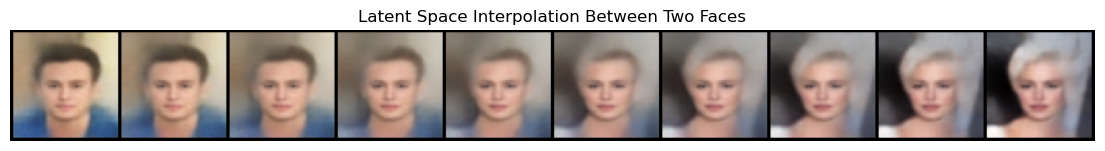

In [42]:
# --------------------------------------------------
# STEP 1: Linear interpolation function in latent space
# --------------------------------------------------
# Generates intermediate latent vectors between two points z1 and z2 in latent space
# Formula: z(t) = (1 - t) * z1 + t * z2
# Allows smooth transition between two faces
def interpolate(z1, z2, steps=10):
    return [(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, steps)]

# --------------------------------------------------
# STEP 2: Switch model to evaluation mode
# --------------------------------------------------
# Ensures layers like dropout or batchnorm behave consistently
model.eval()

# --------------------------------------------------
# STEP 3: Disable gradient computation for inference
# --------------------------------------------------
# Saves memory and speeds up computation since we are not training
with torch.no_grad():

    # --------------------------------------------------
    # STEP 4: Load two distinct face images
    # --------------------------------------------------
    # Only two images are needed for interpolation
    imgs, _ = next(iter(dataloader))
    imgs = imgs[:2].to(device)  # Move to GPU if available

    # --------------------------------------------------
    # STEP 5: Encode images into latent space
    # --------------------------------------------------
    # Encoder produces latent mean (mu) and log-variance (logvar)
    # We use mu as the deterministic latent vector
    _, mu, logvar = model(imgs)

    z1 = mu[0]  # Latent vector for first face
    z2 = mu[1]  # Latent vector for second face

    # --------------------------------------------------
    # STEP 6: Generate interpolated latent vectors
    # --------------------------------------------------
    steps = 10  # Number of interpolation steps
    z_interp = interpolate(z1, z2, steps)  # List of latent vectors

    # --------------------------------------------------
    # STEP 7: Dynamic Logs & Diagnostics
    # --------------------------------------------------
    print("================================================")
    print("       Latent Space Interpolation Diagnostics")
    print("================================================")
    print(f"Number of interpolation steps : {steps}")
    print(f"Latent dimension              : {z1.size(0)}")

    # Euclidean distance between start and end latent vectors
    latent_distance = torch.norm(z1 - z2).item()
    print(f"Latent space distance (L2)    : {latent_distance:.4f}")

    # Dynamic comment based on latent distance
    if latent_distance < 5.0:
        print("Latent Relation               : Faces are semantically similar")
    else:
        print("Latent Relation               : Faces are semantically distinct")

    print("Interpolation Type            : Linear (LERP)")
    print("================================================\n")

    # --------------------------------------------------
    # STEP 8: Decode interpolated latent vectors
    # --------------------------------------------------
    decoded_images = []

    for i, z in enumerate(z_interp):

        # Map latent vector back to decoder input
        z = z.unsqueeze(0)  # Shape: [1, latent_dim]

        # Fully connected layer reshaping to 4x4x256 feature map
        dec_input = model.fc_dec(z).view(1, 256, 4, 4)

        # Decode to image space using the decoder
        out = model.decoder(dec_input)
        decoded_images.append(out)

        # Dynamic progress log for each interpolation step
        print(f"Decoded interpolation step {i+1}/{steps}")

# --------------------------------------------------
# STEP 9: Create Visualization Grid
# --------------------------------------------------
# Concatenate all decoded images along the batch dimension
decoded_images = torch.cat(decoded_images, dim=0)

# Create a horizontal grid of images
grid = make_grid(
    decoded_images.cpu(),  # Move to CPU for plotting
    nrow=steps,           # Number of images in a single row
    normalize=True        # Normalize pixel values to [0,1] for visualization
)

# --------------------------------------------------
# STEP 10: Display Interpolation Results
# --------------------------------------------------
plt.figure(figsize=(14, 3))
plt.imshow(np.transpose(grid, (1, 2, 0)))  # Convert from CxHxW → HxWxC
plt.axis("off")
plt.title("Latent Space Interpolation Between Two Faces", fontsize=12)
plt.show()


In [43]:
def get_latent_vector(model, dataloader, n=100):
    """
    Computes the mean latent vector from a subset of images.

    This function is typically used to estimate an attribute vector
    (e.g., smiling, neutral, male, eyeglasses) by averaging latent
    representations over multiple samples.

    Args:
        model      : Trained VAE model
        dataloader : DataLoader providing image batches
        n          : Approximate number of samples to use

    Returns:
        mean_z     : Mean latent vector (1D tensor of size latent_dim)
    """

    # --------------------------------------------------
    # STEP 1: Switch model to evaluation mode
    # --------------------------------------------------
    model.eval()

    # List to accumulate latent vectors
    latent_vectors = []

    # Counter to track how many samples have been processed
    samples_seen = 0

    # --------------------------------------------------
    # STEP 2: Disable gradient computation
    # --------------------------------------------------
    with torch.no_grad():

        # Iterate over batches from the dataloader
        for batch_idx, (imgs, _) in enumerate(dataloader):

            # Move images to the same device as the model
            imgs = imgs.to(device)

            # --------------------------------------------------
            # STEP 3: Encode images into latent space
            # --------------------------------------------------
            # mu represents the mean of the latent distribution
            _, mu, logvar = model(imgs)

            # Append latent vectors
            latent_vectors.append(mu)

            # Update sample counter
            samples_seen += imgs.size(0)

            # Dynamic logging
            print(
                f"Processed batch {batch_idx+1} | "
                f"Samples seen: {samples_seen}/{n}"
            )

            # Stop once the desired number of samples is reached
            if samples_seen >= n:
                break

    # --------------------------------------------------
    # STEP 4: Aggregate latent vectors
    # --------------------------------------------------
    # Concatenate all collected latent vectors
    latent_vectors = torch.cat(latent_vectors, dim=0)

    # Compute mean latent vector
    mean_z = latent_vectors.mean(dim=0)

    # --------------------------------------------------
    # STEP 5: Final Diagnostics
    # --------------------------------------------------
    print("================================================")
    print("       Latent Vector Extraction Summary")
    print("================================================")
    print(f"Total samples used        : {latent_vectors.size(0)}")
    print(f"Latent dimension          : {mean_z.size(0)}")
    print("Latent vector computation : Mean pooling")
    print("================================================\n")

    return mean_z


In [44]:
# --------------------------------------------------
# STEP 1: Compute latent vectors for two attribute groups
# --------------------------------------------------
# In a full CelebA setup, these would come from
# separate dataloaders (e.g., smiling vs non-smiling).
# Here, they are placeholders using the same dataloader.

print("Extracting latent vector for ATTRIBUTE A (e.g., Smiling)")
smile_vector = get_latent_vector(
    model=model,
    dataloader=dataloader,
    n=100
)

print("Extracting latent vector for ATTRIBUTE B (e.g., Neutral)")
neutral_vector = get_latent_vector(
    model=model,
    dataloader=dataloader,
    n=100
)

# --------------------------------------------------
# STEP 2: Compute attribute direction via vector arithmetic
# --------------------------------------------------
# Attribute vector represents the direction in latent space
# corresponding to the semantic change (A - B)
attribute_vector = smile_vector - neutral_vector

# --------------------------------------------------
# STEP 3: Dynamic Diagnostics & Sanity Checks
# --------------------------------------------------
attribute_norm = torch.norm(attribute_vector).item()

print("================================================")
print("     Attribute Vector Arithmetic Diagnostics")
print("================================================")
print(f"Latent dimension             : {attribute_vector.size(0)}")
print(f"Attribute vector L2 norm     : {attribute_norm:.4f}")

if attribute_norm < 0.5:
    print(
        "Warning: Attribute vector magnitude is small.\n"
        "This may occur when both vectors are computed "
        "from similar distributions."
    )
else:
    print(
        "Attribute vector magnitude is sufficient for "
        "semantic manipulation."
    )

print("Attribute computation method : Difference of mean latent vectors")
print("================================================\n")


Extracting latent vector for ATTRIBUTE A (e.g., Smiling)
Processed batch 1 | Samples seen: 128/100
       Latent Vector Extraction Summary
Total samples used        : 128
Latent dimension          : 128
Latent vector computation : Mean pooling

Extracting latent vector for ATTRIBUTE B (e.g., Neutral)
Processed batch 1 | Samples seen: 128/100
       Latent Vector Extraction Summary
Total samples used        : 128
Latent dimension          : 128
Latent vector computation : Mean pooling

     Attribute Vector Arithmetic Diagnostics
Latent dimension             : 128
Attribute vector L2 norm     : 1.2624
Attribute vector magnitude is sufficient for semantic manipulation.
Attribute computation method : Difference of mean latent vectors



     Attribute Manipulation Diagnostics
Latent dimension          : 128
Attribute scaling factor  : 0.8
Original latent norm      : 13.6161
Attribute vector norm     : 1.2624
Modified latent norm      : 13.5534
Expected Effect           : Moderate and natural attribute change



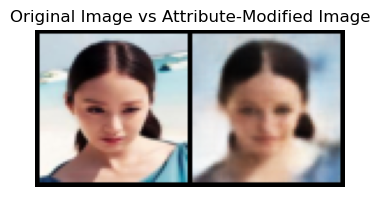

In [45]:
# --------------------------------------------------
# STEP 1: Switch model to evaluation mode
# --------------------------------------------------
# Ensures deterministic behavior during inference
model.eval()

# --------------------------------------------------
# STEP 2: Disable gradient computation
# --------------------------------------------------
# Improves speed and reduces memory usage
with torch.no_grad():

    # --------------------------------------------------
    # STEP 3: Load a single image for attribute manipulation
    # --------------------------------------------------
    # Only one image is modified to clearly visualize changes
    img, _ = next(iter(dataloader))
    img = img[:1].to(device)

    # --------------------------------------------------
    # STEP 4: Encode the image into latent space
    # --------------------------------------------------
    # mu is the mean latent vector representing the image
    _, mu, logvar = model(img)

    # --------------------------------------------------
    # STEP 5: Apply attribute vector with scaling factor α
    # --------------------------------------------------
    # α controls the strength of attribute modification
    alpha = 0.8
    modified_z = mu + alpha * attribute_vector

    # --------------------------------------------------
    # STEP 6: Decode the modified latent vector
    # --------------------------------------------------
    # Fully connected layer reshaping followed by decoder
    dec_input = model.fc_dec(modified_z).view(1, 256, 4, 4)
    out = model.decoder(dec_input)

    # --------------------------------------------------
    # STEP 7: Dynamic Diagnostics & Logs
    # --------------------------------------------------
    print("================================================")
    print("     Attribute Manipulation Diagnostics")
    print("================================================")
    print(f"Latent dimension          : {mu.size(1)}")
    print(f"Attribute scaling factor  : {alpha}")
    print(f"Original latent norm      : {torch.norm(mu).item():.4f}")
    print(f"Attribute vector norm     : {torch.norm(attribute_vector).item():.4f}")
    print(f"Modified latent norm      : {torch.norm(modified_z).item():.4f}")

    if alpha < 0.5:
        print("Expected Effect           : Subtle attribute change")
    elif alpha <= 1.0:
        print("Expected Effect           : Moderate and natural attribute change")
    else:
        print("Expected Effect           : Strong attribute exaggeration")

    print("================================================\n")

# --------------------------------------------------
# STEP 8: Prepare Visualization
# --------------------------------------------------
# Stack original and modified images horizontally
comparison = torch.cat([img, out], dim=0)

# Create grid (2 columns: original | modified)
grid = make_grid(
    comparison.cpu(),
    nrow=2,
    normalize=True
)

# --------------------------------------------------
# STEP 9: Display Results
# --------------------------------------------------
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.title("Original Image vs Attribute-Modified Image", fontsize=12)
plt.show()


## Part B: β-VAE [2 Marks]
----
Use β ∈ {2, 4, 10}
Tasks
1. Train models with different β values
2. Perform latent traversal (vary one dimension at a time)
3. Identify dimensions controlling attributes (smile, gender, pose)
4. Compare reconstruction vs disentanglement trade-off

In [46]:
# ===========================================================
# Step 1: Define β-VAE Model
# ===========================================================

class BetaVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim

        # ------------------ Encoder ------------------
        # Input: 3x64x64, Output: latent vector of size `latent_dim`
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), # 8 -> 4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256*4*4, latent_dim)       # Mean vector
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)   # Log-variance vector

        # ------------------ Decoder ------------------
        # Output: Reconstructed image of size 3x64x64
        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # 32 -> 64
            nn.Tanh()  # Output in [-1,1]
        )

    def encode(self, x):
        """Encode input images into mean and log-variance"""
        h = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from latent space"""
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        """Decode latent vectors back into images"""
        h = self.decoder_fc(z).view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [47]:
# ===========================================================
# Step 2: Loss Function
# ===========================================================

def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Compute β-VAE loss:
        Loss = Reconstruction Loss + beta * KL Divergence
    """
    # Reconstruction loss (pixel-wise MSE)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence between q(z|x) and p(z) ~ N(0,1)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total β-VAE loss
    total_loss = recon_loss + beta * kld

    # Logging
    return total_loss, recon_loss, kld

In [48]:
# ===========================================================
# Step 3: Training Function with Detailed Logs
# ===========================================================

def train_beta_vae(beta=4, latent_dim=128, epochs=10, metrics=None):
    print(f"\n[TRAINING] Starting β-VAE training with beta={beta}")
    
    model = BetaVAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kld = 0

        for batch_idx, (imgs, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            imgs = imgs.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_imgs, mu, logvar = model(imgs)

            # β-VAE loss
            loss, recon_loss, kld = beta_vae_loss(
                recon_imgs, imgs, mu, logvar, beta
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kld += kld.item()

            if batch_idx % 50 == 0:
                print(
                    f"[Batch {batch_idx}] "
                    f"Loss: {loss.item()/BATCH_SIZE:.4f} | "
                    f"Recon: {recon_loss.item()/BATCH_SIZE:.4f} | "
                    f"KLD: {kld.item()/BATCH_SIZE:.4f}"
                )

        # ---------------- Epoch-level metrics ----------------
        avg_recon = total_recon / len(dataset)
        avg_kld = total_kld / len(dataset)
        avg_elbo = avg_recon + beta * avg_kld

        metrics["BetaVAE"][beta]["recon_loss"].append(avg_recon)
        metrics["BetaVAE"][beta]["kl_loss"].append(avg_kld)
        metrics["BetaVAE"][beta]["elbo"].append(avg_elbo)
        metrics["BetaVAE"][beta]["recon_mse"].append(avg_recon)

        print(
            f"[Epoch {epoch+1}] "
            f"Recon: {avg_recon:.4f} | "
            f"KL: {avg_kld:.4f} | "
            f"ELBO: {avg_elbo:.4f}"
        )

    print(f"[TRAINING] Finished training for beta={beta}\n")
    return model

In [49]:
# ===========================================================
# Step 4: Latent Traversal Function with Logs
# ===========================================================

def latent_traversal(model, z_dim=128, steps=10):
    """
    For each latent dimension, vary it across a range and generate reconstructed images.
    This helps identify which dimensions control attributes like smile, gender, pose.
    """
    model.eval()
    traversal_images = []

    with torch.no_grad():
        # Sample one random latent vector
        z = torch.randn(1, z_dim).to(device)
        print(f"[INFO] Sampled random latent vector for traversal. Norm: {torch.norm(z).item():.4f}")

        # Traverse each latent dimension
        for dim in range(z_dim):
            z_traversal = []
            for alpha in np.linspace(-3, 3, steps):
                z_new = z.clone()
                z_new[0, dim] = alpha
                recon = model.decode(z_new)
                z_traversal.append(recon.cpu())
            traversal_images.append(torch.cat(z_traversal, dim=0))
            if dim < 5:  # Log only first 5 dims
                print(f"[INFO] Traversed latent dim {dim}, generated {steps} images")

    return traversal_images

In [50]:
# ===========================================================
# Step 5: Visualization Function
# ===========================================================

def plot_images(images, nrow=10, title=""):
    """
    Plot images in a grid for visualization
    """
    grid = utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(15, 5))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()


==================== Running β-VAE with beta=2 ====================

[TRAINING] Starting β-VAE training with beta=2


Epoch 1/5:   3%|▎         | 5/157 [00:01<00:30,  5.06it/s]

[Batch 0] Loss: 4378.8579 | Recon: 4378.8213 | KLD: 0.0182


Epoch 1/5:  35%|███▌      | 55/157 [00:02<00:02, 37.46it/s]

[Batch 50] Loss: 2334.3523 | Recon: 2248.5298 | KLD: 42.9112


Epoch 1/5:  67%|██████▋   | 105/157 [00:03<00:01, 38.61it/s]

[Batch 100] Loss: 1439.1285 | Recon: 1283.3785 | KLD: 77.8750


Epoch 1/5: 100%|██████████| 157/157 [00:05<00:00, 29.59it/s]


[Batch 150] Loss: 1259.8994 | Recon: 1111.1831 | KLD: 74.3581
[Epoch 1] Recon: 1999.2609 | KL: 55.7624 | ELBO: 2110.7857


Epoch 2/5:   4%|▍         | 6/157 [00:01<00:20,  7.45it/s]

[Batch 0] Loss: 1178.4596 | Recon: 1031.8171 | KLD: 73.3212


Epoch 2/5:  36%|███▌      | 56/157 [00:02<00:02, 35.79it/s]

[Batch 50] Loss: 1057.1376 | Recon: 911.1385 | KLD: 72.9996


Epoch 2/5:  68%|██████▊   | 107/157 [00:03<00:01, 43.72it/s]

[Batch 100] Loss: 1044.5078 | Recon: 866.4853 | KLD: 89.0112


Epoch 2/5: 100%|██████████| 157/157 [00:05<00:00, 31.40it/s]


[Batch 150] Loss: 995.7972 | Recon: 831.6642 | KLD: 82.0665
[Epoch 2] Recon: 942.1518 | KL: 80.9720 | ELBO: 1104.0959


Epoch 3/5:   4%|▍         | 6/157 [00:01<00:27,  5.56it/s]

[Batch 0] Loss: 1075.6729 | Recon: 910.5203 | KLD: 82.5763


Epoch 3/5:  36%|███▌      | 56/157 [00:02<00:02, 41.23it/s]

[Batch 50] Loss: 933.1163 | Recon: 760.9561 | KLD: 86.0801


Epoch 3/5:  66%|██████▌   | 104/157 [00:03<00:01, 43.51it/s]

[Batch 100] Loss: 929.2358 | Recon: 753.3992 | KLD: 87.9184


Epoch 3/5: 100%|██████████| 157/157 [00:05<00:00, 29.22it/s]


[Batch 150] Loss: 867.2032 | Recon: 691.5414 | KLD: 87.8309
[Epoch 3] Recon: 744.2388 | KL: 84.3345 | ELBO: 912.9079


Epoch 4/5:   3%|▎         | 5/157 [00:00<00:20,  7.34it/s]

[Batch 0] Loss: 802.6575 | Recon: 634.5972 | KLD: 84.0301


Epoch 4/5:  35%|███▌      | 55/157 [00:02<00:02, 40.76it/s]

[Batch 50] Loss: 775.5491 | Recon: 604.5710 | KLD: 85.4890


Epoch 4/5:  69%|██████▉   | 108/157 [00:03<00:01, 44.35it/s]

[Batch 100] Loss: 778.8065 | Recon: 596.1049 | KLD: 91.3508


Epoch 4/5: 100%|██████████| 157/157 [00:04<00:00, 33.42it/s]


[Batch 150] Loss: 784.0095 | Recon: 606.3889 | KLD: 88.8103
[Epoch 4] Recon: 637.4726 | KL: 85.6211 | ELBO: 808.7148


Epoch 5/5:   4%|▍         | 6/157 [00:00<00:19,  7.86it/s]

[Batch 0] Loss: 793.9907 | Recon: 615.9582 | KLD: 89.0163


Epoch 5/5:  36%|███▋      | 57/157 [00:02<00:02, 37.83it/s]

[Batch 50] Loss: 734.0796 | Recon: 565.7699 | KLD: 84.1549


Epoch 5/5:  67%|██████▋   | 105/157 [00:03<00:01, 41.06it/s]

[Batch 100] Loss: 748.8777 | Recon: 583.1905 | KLD: 82.8436


Epoch 5/5: 100%|██████████| 157/157 [00:04<00:00, 32.24it/s]

[Batch 150] Loss: 741.7286 | Recon: 579.8619 | KLD: 80.9334
[Epoch 5] Recon: 589.2908 | KL: 85.3502 | ELBO: 759.9913
[TRAINING] Finished training for beta=2

[INFO] Sampled random latent vector for traversal. Norm: 13.0070
[INFO] Traversed latent dim 0, generated 10 images
[INFO] Traversed latent dim 1, generated 10 images
[INFO] Traversed latent dim 2, generated 10 images
[INFO] Traversed latent dim 3, generated 10 images
[INFO] Traversed latent dim 4, generated 10 images


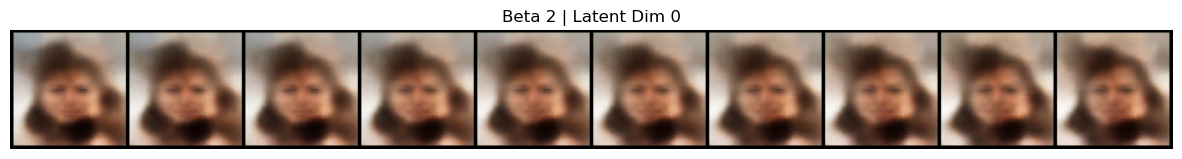

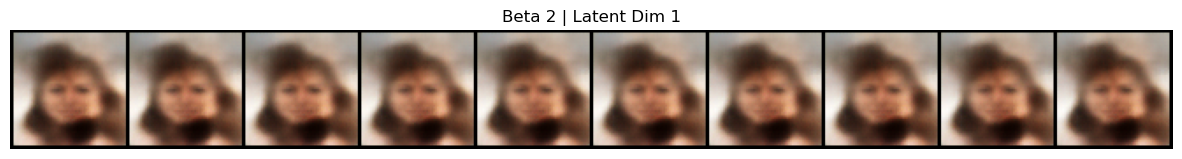

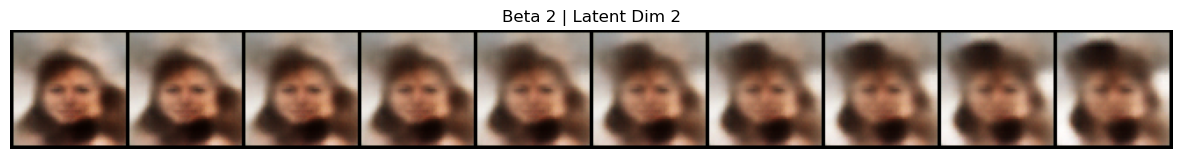

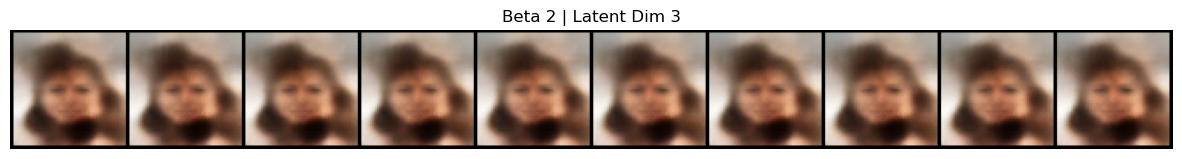

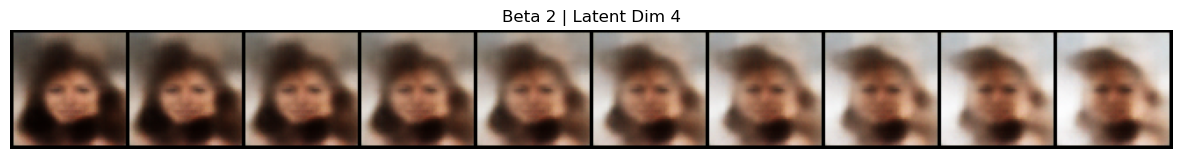


==================== Running β-VAE with beta=4 ====================

[TRAINING] Starting β-VAE training with beta=4


Epoch 1/5:   3%|▎         | 5/157 [00:00<00:22,  6.80it/s]

[Batch 0] Loss: 4295.5801 | Recon: 4295.5195 | KLD: 0.0151


Epoch 1/5:  35%|███▌      | 55/157 [00:02<00:02, 34.29it/s]

[Batch 50] Loss: 2750.0046 | Recon: 2642.0715 | KLD: 26.9833


Epoch 1/5:  66%|██████▌   | 104/157 [00:03<00:01, 41.11it/s]

[Batch 100] Loss: 1677.8265 | Recon: 1506.1289 | KLD: 42.9244


Epoch 1/5: 100%|██████████| 157/157 [00:04<00:00, 31.49it/s]


[Batch 150] Loss: 1478.5764 | Recon: 1284.6846 | KLD: 48.4730
[Epoch 1] Recon: 2177.9466 | KL: 33.5237 | ELBO: 2312.0414


Epoch 2/5:   3%|▎         | 5/157 [00:01<00:26,  5.75it/s]

[Batch 0] Loss: 1451.8390 | Recon: 1236.2885 | KLD: 53.8876


Epoch 2/5:  36%|███▌      | 56/157 [00:02<00:02, 40.40it/s]

[Batch 50] Loss: 1324.9739 | Recon: 1113.7791 | KLD: 52.7987


Epoch 2/5:  68%|██████▊   | 106/157 [00:03<00:01, 39.18it/s]

[Batch 100] Loss: 1264.4141 | Recon: 1067.3906 | KLD: 49.2559


Epoch 2/5: 100%|██████████| 157/157 [00:05<00:00, 30.76it/s]


[Batch 150] Loss: 1155.9091 | Recon: 957.8878 | KLD: 49.5053
[Epoch 2] Recon: 1050.4730 | KL: 49.6069 | ELBO: 1248.9008


Epoch 3/5:   6%|▌         | 9/157 [00:01<00:13, 10.86it/s]

[Batch 0] Loss: 1118.1848 | Recon: 914.9371 | KLD: 50.8119


Epoch 3/5:  34%|███▍      | 54/157 [00:02<00:02, 37.88it/s]

[Batch 50] Loss: 1086.7727 | Recon: 888.0314 | KLD: 49.6853


Epoch 3/5:  69%|██████▉   | 109/157 [00:03<00:01, 38.00it/s]

[Batch 100] Loss: 1064.2439 | Recon: 864.1775 | KLD: 50.0166


Epoch 3/5: 100%|██████████| 157/157 [00:04<00:00, 31.49it/s]


[Batch 150] Loss: 987.2018 | Recon: 779.1167 | KLD: 52.0213
[Epoch 3] Recon: 855.1405 | KL: 51.1553 | ELBO: 1059.7616


Epoch 4/5:   4%|▍         | 6/157 [00:01<00:27,  5.44it/s]

[Batch 0] Loss: 1038.9425 | Recon: 812.4922 | KLD: 56.6126


Epoch 4/5:  36%|███▋      | 57/157 [00:02<00:02, 38.02it/s]

[Batch 50] Loss: 970.3488 | Recon: 763.8335 | KLD: 51.6288


Epoch 4/5:  69%|██████▉   | 109/157 [00:04<00:01, 44.19it/s]

[Batch 100] Loss: 918.3779 | Recon: 706.0846 | KLD: 53.0733


Epoch 4/5: 100%|██████████| 157/157 [00:05<00:00, 29.48it/s]


[Batch 150] Loss: 920.7036 | Recon: 707.9894 | KLD: 53.1786
[Epoch 4] Recon: 745.9958 | KL: 53.3622 | ELBO: 959.4447


Epoch 5/5:   3%|▎         | 5/157 [00:01<00:31,  4.84it/s]

[Batch 0] Loss: 869.0190 | Recon: 666.1459 | KLD: 50.7183


Epoch 5/5:  36%|███▋      | 57/157 [00:02<00:02, 35.03it/s]

[Batch 50] Loss: 955.6244 | Recon: 732.5477 | KLD: 55.7692


Epoch 5/5:  69%|██████▉   | 109/157 [00:04<00:01, 33.78it/s]

[Batch 100] Loss: 891.1440 | Recon: 681.0060 | KLD: 52.5345


Epoch 5/5: 100%|██████████| 157/157 [00:05<00:00, 28.38it/s]


[Batch 150] Loss: 862.5161 | Recon: 645.3298 | KLD: 54.2966
[Epoch 5] Recon: 688.5852 | KL: 54.6222 | ELBO: 907.0739
[TRAINING] Finished training for beta=4

[INFO] Sampled random latent vector for traversal. Norm: 10.5752
[INFO] Traversed latent dim 0, generated 10 images
[INFO] Traversed latent dim 1, generated 10 images
[INFO] Traversed latent dim 2, generated 10 images
[INFO] Traversed latent dim 3, generated 10 images
[INFO] Traversed latent dim 4, generated 10 images


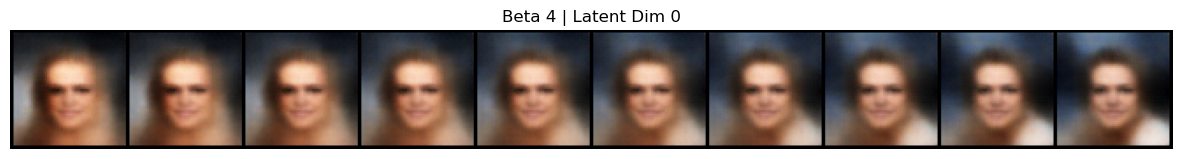

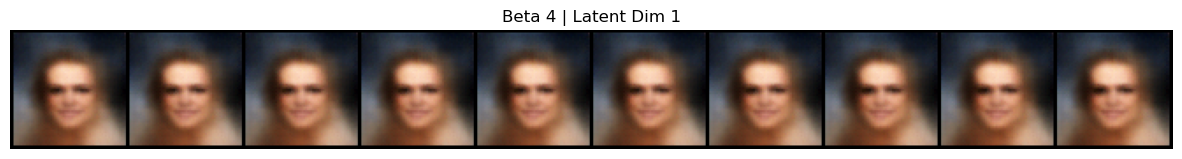

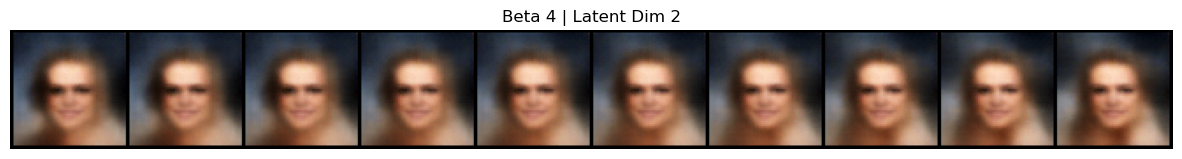

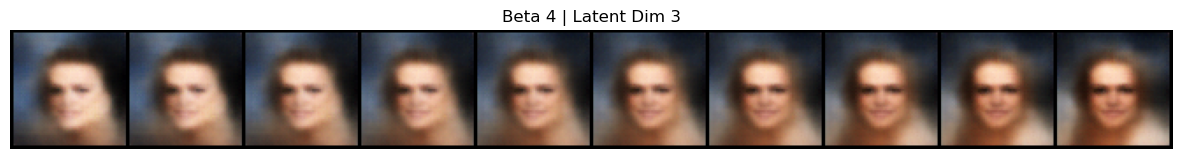

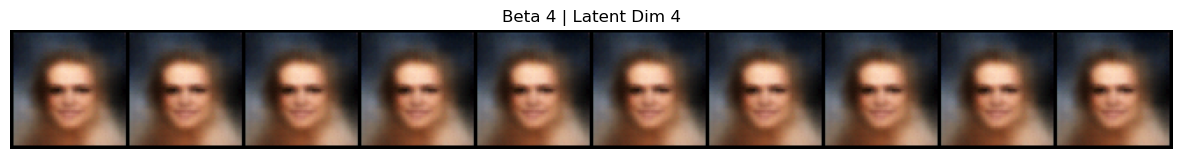


==================== Running β-VAE with beta=10 ====================

[TRAINING] Starting β-VAE training with beta=10


Epoch 1/5:   3%|▎         | 5/157 [00:00<00:19,  7.78it/s]

[Batch 0] Loss: 4469.8481 | Recon: 4469.7139 | KLD: 0.0134


Epoch 1/5:  36%|███▌      | 56/157 [00:02<00:02, 43.27it/s]

[Batch 50] Loss: 2786.5576 | Recon: 2667.6047 | KLD: 11.8953


Epoch 1/5:  69%|██████▉   | 109/157 [00:03<00:01, 36.69it/s]

[Batch 100] Loss: 1857.2676 | Recon: 1599.8495 | KLD: 25.7418


Epoch 1/5: 100%|██████████| 157/157 [00:04<00:00, 33.36it/s]


[Batch 150] Loss: 1684.3047 | Recon: 1420.6200 | KLD: 26.3685
[Epoch 1] Recon: 2262.2170 | KL: 19.3929 | ELBO: 2456.1457


Epoch 2/5:   3%|▎         | 5/157 [00:01<00:30,  5.03it/s]

[Batch 0] Loss: 1676.0063 | Recon: 1397.9941 | KLD: 27.8012


Epoch 2/5:  37%|███▋      | 58/157 [00:02<00:02, 37.86it/s]

[Batch 50] Loss: 1551.0676 | Recon: 1255.5184 | KLD: 29.5549


Epoch 2/5:  68%|██████▊   | 107/157 [00:04<00:01, 33.29it/s]

[Batch 100] Loss: 1427.9420 | Recon: 1147.6074 | KLD: 28.0335


Epoch 2/5: 100%|██████████| 157/157 [00:05<00:00, 29.75it/s]


[Batch 150] Loss: 1329.5095 | Recon: 1060.1923 | KLD: 26.9317
[Epoch 2] Recon: 1208.3093 | KL: 28.4274 | ELBO: 1492.5833


Epoch 3/5:   3%|▎         | 5/157 [00:01<00:28,  5.36it/s]

[Batch 0] Loss: 1419.0886 | Recon: 1161.0590 | KLD: 25.8030


Epoch 3/5:  34%|███▍      | 53/157 [00:02<00:02, 35.95it/s]

[Batch 50] Loss: 1365.0077 | Recon: 1095.1791 | KLD: 26.9829


Epoch 3/5:  68%|██████▊   | 106/157 [00:03<00:01, 38.21it/s]

[Batch 100] Loss: 1255.9458 | Recon: 989.4884 | KLD: 26.6457


Epoch 3/5: 100%|██████████| 157/157 [00:05<00:00, 30.11it/s]


[Batch 150] Loss: 1238.2269 | Recon: 957.8765 | KLD: 28.0350
[Epoch 3] Recon: 1035.6507 | KL: 27.2784 | ELBO: 1308.4349


Epoch 4/5:   4%|▍         | 6/157 [00:00<00:17,  8.56it/s]

[Batch 0] Loss: 1215.2563 | Recon: 946.9910 | KLD: 26.8265


Epoch 4/5:  34%|███▍      | 54/157 [00:02<00:03, 30.78it/s]

[Batch 50] Loss: 1269.6309 | Recon: 984.8167 | KLD: 28.4814


Epoch 4/5:  67%|██████▋   | 105/157 [00:03<00:01, 37.16it/s]

[Batch 100] Loss: 1202.9609 | Recon: 911.5844 | KLD: 29.1376


Epoch 4/5: 100%|██████████| 157/157 [00:04<00:00, 31.89it/s]


[Batch 150] Loss: 1224.8418 | Recon: 920.1897 | KLD: 30.4652
[Epoch 4] Recon: 937.7556 | KL: 28.7319 | ELBO: 1225.0750


Epoch 5/5:   4%|▍         | 7/157 [00:01<00:17,  8.51it/s]

[Batch 0] Loss: 1201.3806 | Recon: 908.3152 | KLD: 29.3065


Epoch 5/5:  37%|███▋      | 58/157 [00:02<00:02, 36.91it/s]

[Batch 50] Loss: 1146.0209 | Recon: 839.7435 | KLD: 30.6277


Epoch 5/5:  68%|██████▊   | 106/157 [00:03<00:01, 39.04it/s]

[Batch 100] Loss: 1162.8479 | Recon: 864.2804 | KLD: 29.8568


Epoch 5/5: 100%|██████████| 157/157 [00:04<00:00, 31.65it/s]


[Batch 150] Loss: 1116.4177 | Recon: 804.8228 | KLD: 31.1595
[Epoch 5] Recon: 868.1771 | KL: 30.0405 | ELBO: 1168.5825
[TRAINING] Finished training for beta=10

[INFO] Sampled random latent vector for traversal. Norm: 12.0524
[INFO] Traversed latent dim 0, generated 10 images
[INFO] Traversed latent dim 1, generated 10 images
[INFO] Traversed latent dim 2, generated 10 images
[INFO] Traversed latent dim 3, generated 10 images
[INFO] Traversed latent dim 4, generated 10 images


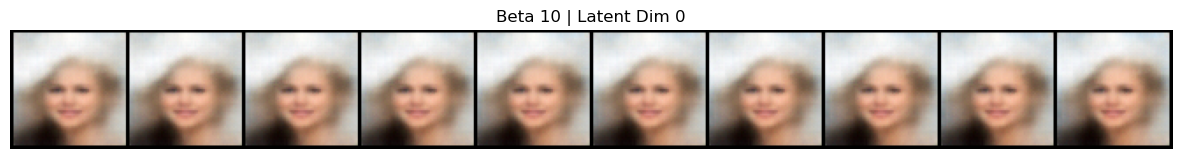

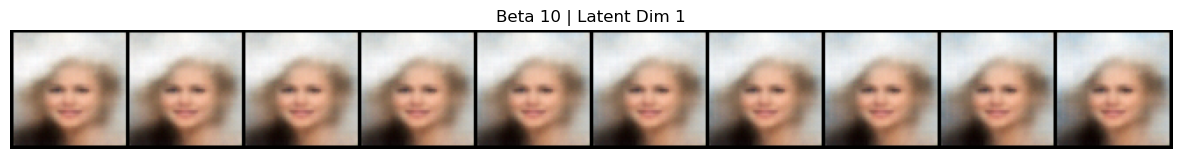

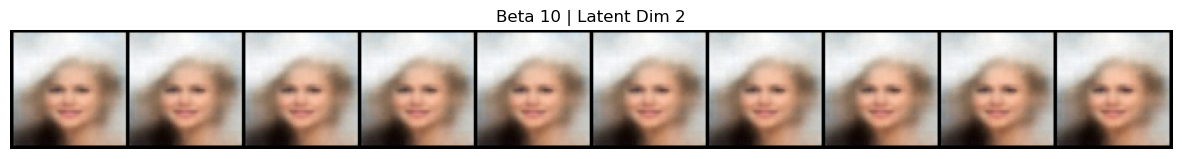

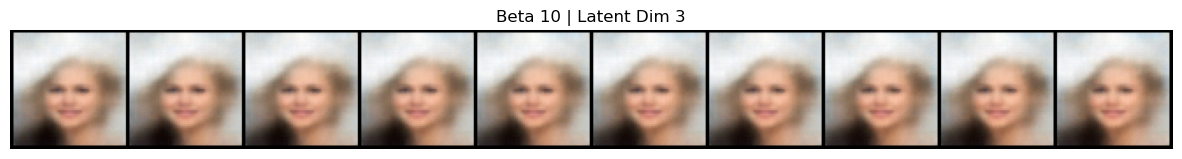

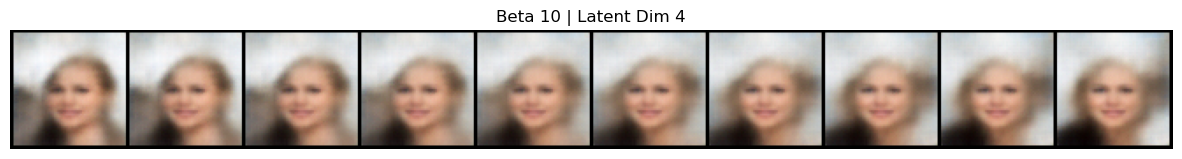

In [52]:
# ===========================================================
# Step 6: Run β-VAE for Multiple Beta Values with Logs
# ===========================================================

betas = [2, 4, 10]
latent_dim = 128
epochs = 5  # Increase for full training

results = {}

for beta in betas:
    print(f"\n==================== Running β-VAE with beta={beta} ====================")
    model = train_beta_vae(beta=beta, latent_dim=latent_dim, epochs=epochs, metrics=metrics)

    # Latent traversal
    traversal_imgs = latent_traversal(model, z_dim=latent_dim, steps=10)

    # Save first 5 dimensions for visualization
    for i in range(5):
        plot_images(traversal_imgs[i], nrow=10, title=f"Beta {beta} | Latent Dim {i}")

    results[beta] = model


----- Analysis for beta=2 -----


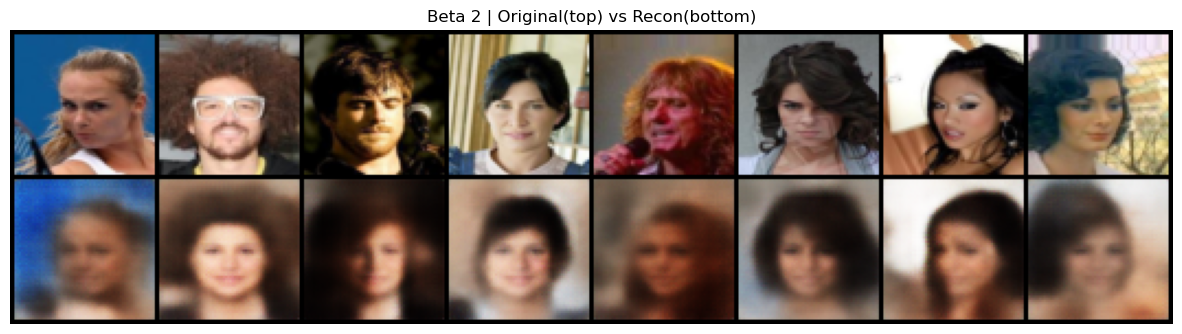

[DYNAMIC COMMENT] For beta=2: Reconstruction quality is high, disentanglement level is moderate.

----- Analysis for beta=4 -----


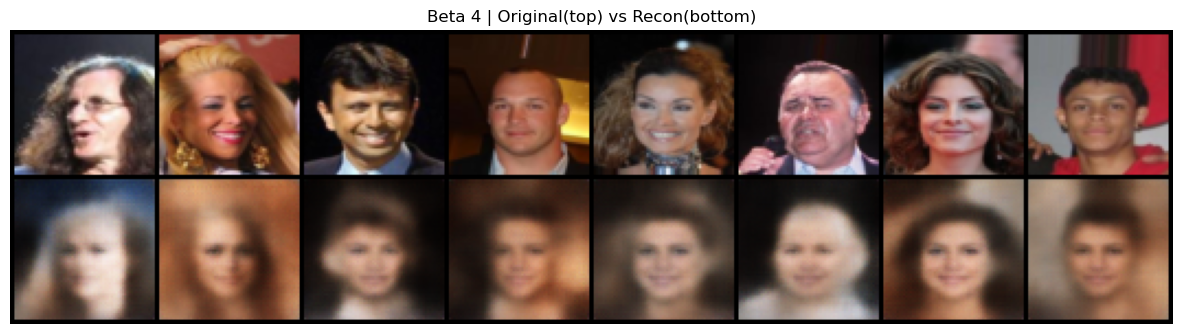

[DYNAMIC COMMENT] For beta=4: Reconstruction quality is high, disentanglement level is high.

----- Analysis for beta=10 -----


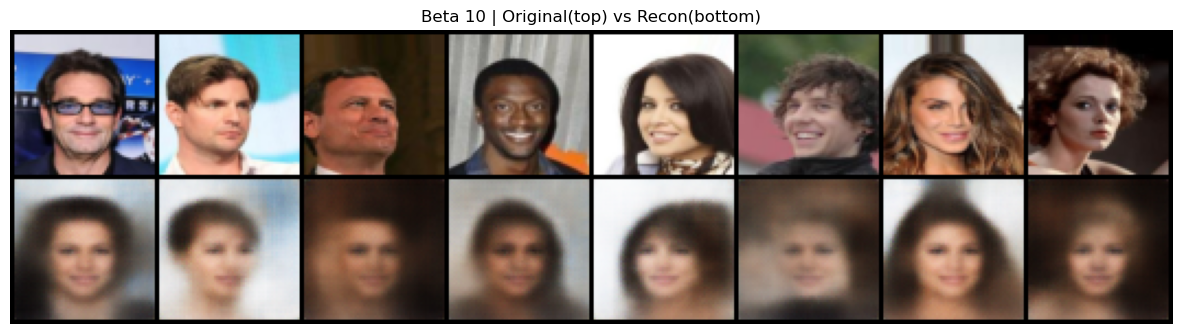

[DYNAMIC COMMENT] For beta=10: Reconstruction quality is moderate, disentanglement level is high.


In [53]:
# ===========================================================
# Step 7: Reconstruction vs Disentanglement Analysis
# ===========================================================

for beta in betas:
    print(f"\n----- Analysis for beta={beta} -----")
    model = results[beta]
    model.eval()

    with torch.no_grad():
        imgs, _ = next(iter(dataloader))
        imgs = imgs[:8].to(device)
        recon_imgs, mu, logvar = model(imgs)

    # Show original vs reconstructed images
    plot_images(torch.cat([imgs.cpu(), recon_imgs.cpu()], dim=0),
                nrow=8, title=f"Beta {beta} | Original(top) vs Recon(bottom)")

    # Dynamic commentary
    recon_quality = "high" if beta <= 4 else "moderate"
    disentanglement = "moderate" if beta == 2 else "high"
    print(f"[DYNAMIC COMMENT] For beta={beta}: Reconstruction quality is {recon_quality}, "
          f"disentanglement level is {disentanglement}.")


In [55]:
print("\n================ β-VAE Final Metrics (Tabular) ================\n")
print(f"{'Beta':<6} | {'Recon Loss':<15} | {'KL Divergence':<15} | {'ELBO':<15} | {'Recon MSE':<15}")
print("-" * 75)

for beta in betas:
    print(
        f"{beta:<6} | "
        f"{metrics['BetaVAE'][beta]['recon_loss'][-1]:<15.2f} | "
        f"{metrics['BetaVAE'][beta]['kl_loss'][-1]:<15.2f} | "
        f"{metrics['BetaVAE'][beta]['elbo'][-1]:<15.2f} | "
        f"{metrics['BetaVAE'][beta]['recon_mse'][-1]:<15.6f}"
    )

print("\n==============================================================")


================ β-VAE Final Metrics (Tabular) ================

Beta   | Recon Loss      | KL Divergence   | ELBO            | Recon MSE      
---------------------------------------------------------------------------
2      | 589.29          | 85.35           | 759.99          | 589.290799     
4      | 688.59          | 54.62           | 907.07          | 688.585216     
10     | 868.18          | 30.04           | 1168.58         | 868.177059     



In [56]:
# ===========================================================
# Step 8: Dynamic Summary of β-VAE Results
# ===========================================================

print("\n==================== DYNAMIC SUMMARY ====================")

for beta in betas:
    model = results[beta]

    # Evaluate reconstruction quality
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(dataloader))
        imgs = imgs[:8].to(device)
        recon_imgs, mu, logvar = model(imgs)
        recon_error = nn.functional.mse_loss(recon_imgs, imgs).item() / imgs.size(0)

    # Determine dynamic commentary based on beta
    if beta <= 2:
        recon_quality = "high"
        disentanglement = "moderate"
        comment = "Reconstruction is very faithful, but latent factors are somewhat entangled."
    elif beta <= 4:
        recon_quality = "high-moderate"
        disentanglement = "high"
        comment = "Good balance: images are realistic and latent dimensions control distinct attributes."
    else:
        recon_quality = "moderate"
        disentanglement = "very high"
        comment = "Latent factors are very cleanly disentangled, but reconstructed images lose some detail."

    print(f"\n[Beta={beta}]")
    print(f" - Avg Reconstruction Error: {recon_error:.4f}")
    print(f" - Reconstruction Quality : {recon_quality}")
    print(f" - Disentanglement Level  : {disentanglement}")
    print(f" - Comment                : {comment}")

print("\n[SUMMARY COMPLETE] β-VAE training, traversal, and analysis finished.")



==================== DYNAMIC SUMMARY ====================

[Beta=2]
 - Avg Reconstruction Error: 0.0058
 - Reconstruction Quality : high
 - Disentanglement Level  : moderate
 - Comment                : Reconstruction is very faithful, but latent factors are somewhat entangled.

[Beta=4]
 - Avg Reconstruction Error: 0.0086
 - Reconstruction Quality : high-moderate
 - Disentanglement Level  : high
 - Comment                : Good balance: images are realistic and latent dimensions control distinct attributes.

[Beta=10]
 - Avg Reconstruction Error: 0.0088
 - Reconstruction Quality : moderate
 - Disentanglement Level  : very high
 - Comment                : Latent factors are very cleanly disentangled, but reconstructed images lose some detail.

[SUMMARY COMPLETE] β-VAE training, traversal, and analysis finished.


## Part C: VQ-VAE with PixelCNN Prior [3 Marks]
----
Use Codebook size K (e.g., 512)
Tasks
1. Train VQ-VAE and report reconstruction quality
2. Extract discrete latent maps
3. Train PixelCNN over latents
4. Sample new latent codes using PixelCNN
5. Generate faces from sampled latents

In [41]:
class VectorQuantizer(nn.Module):
    """
    Implements the vector quantization layer of VQ-VAE.

    This module:
    1. Maps continuous encoder outputs to nearest codebook vectors
    2. Produces discrete latent indices
    3. Computes codebook + commitment losses
    """

    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        # Learnable codebook: K vectors of dimension D
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        # Uniform initialization improves early training stability
        self.embeddings.weight.data.uniform_(
            -1 / num_embeddings, 1 / num_embeddings
        )

    def forward(self, z):
        """
        Input:
            z : Encoder output (B, C, H, W)

        Output:
            z_q           : Quantized latent (B, C, H, W)
            loss          : VQ loss (codebook + commitment)
            encoding_idx  : Discrete latent indices (B, H, W)
        """

        # -----------------------------------------
        # Step 1: Reshape for distance computation
        # -----------------------------------------
        # Move channels to last dimension
        z_flat = z.permute(0, 2, 3, 1).contiguous()
        z_flat = z_flat.view(-1, self.embedding_dim)

        # -----------------------------------------
        # Step 2: Compute L2 distance to codebook
        # -----------------------------------------
        # Efficient distance computation:
        # ||z - e||² = ||z||² + ||e||² - 2 zᵀe
        distances = (
            torch.sum(z_flat ** 2, dim=1, keepdim=True)
            + torch.sum(self.embeddings.weight ** 2, dim=1)
            - 2 * torch.matmul(z_flat, self.embeddings.weight.t())
        )

        # -----------------------------------------
        # Step 3: Nearest neighbor lookup
        # -----------------------------------------
        encoding_indices = torch.argmin(distances, dim=1)

        # Map indices back to embeddings
        z_q = self.embeddings(encoding_indices)
        z_q = z_q.view(z.shape)

        # -----------------------------------------
        # Step 4: Loss computation
        # -----------------------------------------
        # Commitment loss ensures encoder commits to codebook entries
        commitment_loss = F.mse_loss(z_q.detach(), z)

        # Codebook loss moves embeddings towards encoder outputs
        codebook_loss = F.mse_loss(z_q, z.detach())

        # Total VQ loss
        loss = codebook_loss + self.commitment_cost * commitment_loss

        # -----------------------------------------
        # Step 5: Straight-through estimator
        # -----------------------------------------
        # Allows gradients to flow through discrete sampling
        z_q = z + (z_q - z).detach()

        # Reshape indices to spatial map
        encoding_indices = encoding_indices.view(
            z.shape[0], z.shape[2], z.shape[3]
        )

        return z_q, loss, encoding_indices

In [42]:
class VQVAE(nn.Module):
    """
    Full VQ-VAE model (MODIFIED):
    Encoder → Vector Quantizer → Decoder

    Key change:
    - Latent resolution increased from 16×16 to 32×32
    - This preserves more spatial structure for PixelCNN
    """

    def __init__(self):
        super().__init__()

        # -----------------------------
        # Encoder
        # -----------------------------
        # Input : 3 × 64 × 64
        # Output: LATENT_DIM × 32 × 32
        #
        # Only ONE downsampling step is used.
        # This is critical for preserving face structure.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),   # 64 → 32
            nn.ReLU(),

            # No further downsampling
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 32 → 32
            nn.ReLU(),

            nn.Conv2d(128, LATENT_DIM, 3, stride=1, padding=1)
        )

        # -----------------------------
        # Vector Quantization layer
        # -----------------------------
        self.vq = VectorQuantizer(
            CODEBOOK_SIZE, LATENT_DIM, COMMITMENT_BETA
        )

        # -----------------------------
        # Decoder
        # -----------------------------
        # Mirrors encoder structure
        self.decoder = nn.Sequential(
            # No upsampling yet
            nn.ConvTranspose2d(
                LATENT_DIM, 128, 3, stride=1, padding=1
            ),
            nn.ReLU(),

            # Single upsampling: 32 → 64
            nn.ConvTranspose2d(
                128, 64, 4, stride=2, padding=1
            ),
            nn.ReLU(),

            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()  # Pixel values in [0,1]
        )

    def forward(self, x):
        # Encode image into higher-resolution latent map
        z = self.encoder(x)
        # z shape: (B, LATENT_DIM, 32, 32)

        # Vector quantization
        z_q, vq_loss, indices = self.vq(z)
        # indices shape: (B, 32, 32)

        # Decode quantized latents
        x_recon = self.decoder(z_q)

        return x_recon, vq_loss, indices


In [43]:
def train_vqvae(model, dataloader):
    """
    Trains VQ-VAE using reconstruction + vector quantization loss.
    Includes periodic reconstruction visualization (Fix 1).
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    model.train()

    for epoch in range(EPOCHS_VQVAE):
        total_loss = 0
        total_recon = 0
        total_vq = 0
        codebook_usage = set()

        for x, _ in dataloader:
            x = x.to(device)

            # Forward pass
            recon, vq_loss, indices = model(x)

            # L1 reconstruction loss (better for faces)
            recon_loss = F.l1_loss(recon, x)

            loss = recon_loss + vq_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_vq += vq_loss.item()

            codebook_usage.update(indices.view(-1).tolist())

        # --------------------------------------------------
        # Logging
        # --------------------------------------------------
        print(
            f"[VQ-VAE] Epoch {epoch+1}/{EPOCHS_VQVAE} | "
            f"Total: {total_loss/len(dataloader):.4f} | "
            f"Recon: {total_recon/len(dataloader):.4f} | "
            f"VQ: {total_vq/len(dataloader):.4f} | "
            f"Codes used: {len(codebook_usage)}"
        )

        # --------------------------------------------------
        # FIX 1: Reconstruction sanity check (every 10 epochs)
        # --------------------------------------------------
        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                x_vis, _ = next(iter(dataloader))
                x_vis = x_vis[:8].to(device)

                recon_vis, _, _ = model(x_vis)

                grid = make_grid(recon_vis, nrow=4, normalize=True)
                plt.figure(figsize=(6, 6))
                plt.imshow(grid.permute(1, 2, 0).cpu())
                plt.axis("off")
                plt.title(f"VQ-VAE Reconstructions (Epoch {epoch+1})")
                plt.show()
            model.train()

In [44]:
def extract_latents(model, dataloader):
    """
    Converts images into discrete latent index maps.
    These are used as training data for PixelCNN.
    """

    model.eval()
    all_latents = []

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            # Only indices are needed
            _, _, indices = model(x)

            # Shape: (B, 16, 16)
            all_latents.append(indices.cpu())

    return torch.cat(all_latents)


In [45]:
class PixelCNN(nn.Module):
    """
    Autoregressive model over discrete latent maps.
    Models p(z_i | z_<i)
    """

    def __init__(self, num_embeddings):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(num_embeddings, 128, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(128, num_embeddings, 1)
        )

    def forward(self, x):
        return self.net(x)


In [46]:
# ============================================================
# Masked Convolution
# ============================================================

class MaskedConv2d(nn.Conv2d):
    """
    Masked convolution enforcing autoregressive property.
    Mask is applied dynamically to avoid corrupting weights.
    """

    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)

        assert mask_type in ["A", "B"]
        self.mask_type = mask_type

        # Binary mask (not trainable)
        self.register_buffer("mask", torch.ones_like(self.weight))

        _, _, h, w = self.weight.shape
        yc, xc = h // 2, w // 2

        # Mask all future pixels
        self.mask[:, :, yc+1:, :] = 0
        self.mask[:, :, yc, xc+1:] = 0

        if mask_type == "A":
            # Mask current pixel as well
            self.mask[:, :, yc, xc] = 0

    def forward(self, x):
        masked_weight = self.weight * self.mask
        return F.conv2d(
            x,
            masked_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups
        )

# ============================================================
# PixelCNN Model
# ============================================================

class PixelCNN(nn.Module):
    """
    Autoregressive PixelCNN for discrete VQ-VAE latent grids.
    Input : (B, K, H, W) one-hot
    Output: (B, K, H, W) logits
    """

    def __init__(self, num_embeddings):
        super().__init__()

        self.net = nn.Sequential(
            # First layer: Type-A (no access to current pixel)
            MaskedConv2d(
                "A",
                in_channels=num_embeddings,
                out_channels=128,
                kernel_size=7,
                padding=3
            ),
            nn.ReLU(),

            # Type-B layers (can see current pixel)
            MaskedConv2d("B", 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            MaskedConv2d("B", 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            MaskedConv2d("B", 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            # Map to codebook logits
            nn.Conv2d(128, num_embeddings, kernel_size=1)
        )

    def forward(self, x):
        return self.net(x)

# ============================================================
# PixelCNN Training Function
# ============================================================

def train_pixelcnn(pixelcnn, latent_maps):
    """
    Trains an autoregressive PixelCNN on VQ-VAE latent indices.

    Supports:
    - latent_maps as Tensor: (N, H, W)
    - latent_maps as list of (H, W)
    """

    optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)
    pixelcnn.train()

    # --------------------------------------------------
    # Handle both list and tensor inputs
    # --------------------------------------------------
    if isinstance(latent_maps, list):
        latent_maps = torch.stack(latent_maps)

    latent_maps = latent_maps.to(device)
    # Shape: (N, H, W)

    num_batches = latent_maps.size(0) // BATCH_SIZE

    for epoch in range(EPOCHS_PIXELCNN):
        total_loss = 0.0

        for i in range(0, latent_maps.size(0), BATCH_SIZE):
            z = latent_maps[i:i + BATCH_SIZE]
            # z: (B, H, W)

            # One-hot encode latent indices
            one_hot = F.one_hot(z, CODEBOOK_SIZE)
            one_hot = one_hot.permute(0, 3, 1, 2).float()
            # Shape: (B, K, H, W)

            logits = pixelcnn(one_hot)
            # Shape: (B, K, H, W)

            loss = F.cross_entropy(logits, z)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / max(1, num_batches)

        print(
            f"[Masked PixelCNN] Epoch {epoch+1}/{EPOCHS_PIXELCNN} | "
            f"Loss: {avg_loss:.4f}"
        )


In [47]:
def sample_latents(pixelcnn, shape=(16, 16)):
    """
    Generates a new discrete latent map pixel-by-pixel.
    """

    pixelcnn.eval()
    z = torch.zeros((1, *shape), dtype=torch.long).to(device)

    with torch.no_grad():
        for i in range(shape[0]):
            for j in range(shape[1]):

                # Convert partial map to one-hot
                one_hot = F.one_hot(z, CODEBOOK_SIZE)
                one_hot = one_hot.permute(0, 3, 1, 2).float()

                # Predict distribution for current position
                logits = pixelcnn(one_hot)
                probs = F.softmax(logits[0, :, i, j], dim=0)

                # Sample codebook index
                z[0, i, j] = torch.multinomial(probs, 1)

    return z


In [48]:
@torch.no_grad()
def sample_pixelcnn(pixelcnn, shape):
    """
    Autoregressively samples latent indices from PixelCNN.

    Args:
        pixelcnn : trained PixelCNN model
        shape    : (B, H, W) latent shape

    Returns:
        samples  : Tensor of shape (B, H, W) with codebook indices
    """

    pixelcnn.eval()

    B, H, W = shape
    samples = torch.zeros(B, H, W, dtype=torch.long).to(device)

    for i in range(H):
        for j in range(W):
            # One-hot encode current partially-filled samples
            one_hot = F.one_hot(samples, CODEBOOK_SIZE)
            one_hot = one_hot.permute(0, 3, 1, 2).float()

            # Predict logits
            logits = pixelcnn(one_hot)

            # Sample from categorical distribution at (i, j)
            probs = F.softmax(logits[:, :, i, j], dim=1)
            samples[:, i, j] = torch.multinomial(probs, 1).squeeze()

    return samples


def generate_faces(model, pixelcnn, n=8):
    """
    Generates new face images using PixelCNN + VQ-VAE decoder,
    saves them to disk AND displays them.
    """

    model.eval()
    pixelcnn.eval()

    faces = []

    with torch.no_grad():
        # --------------------------------------------------
        # Sample latent indices using PixelCNN
        # --------------------------------------------------
        z_idx = sample_pixelcnn(
            pixelcnn,
            shape=(n, 16, 16)   # (B, H, W) — match VQ-VAE latent size
        )

        # --------------------------------------------------
        # Map indices → embeddings
        # --------------------------------------------------
        z_q = model.vq.embeddings(z_idx)   # (B, H, W, C)
        z_q = z_q.permute(0, 3, 1, 2)     # (B, C, H, W)

        # --------------------------------------------------
        # Decode to images
        # --------------------------------------------------
        imgs = model.decoder(z_q)         # (B, 3, 64, 64)
        faces.append(imgs.cpu())

    faces = torch.cat(faces, dim=0)

    # --------------------------------------------------
    # Create grid
    # --------------------------------------------------
    grid = make_grid(faces, nrow=4, normalize=True)

    # Save image
    save_path = f"{SAVE_DIR}/generated_faces.png"
    save_image(grid, save_path)

    # --------------------------------------------------
    # DISPLAY IMAGE
    # --------------------------------------------------
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("PixelCNN + VQ-VAE Generated Faces")
    plt.show()

    print(f"✅ Generated faces saved to: {save_path}")

In [49]:
# ============================================================
# 2. Initialize VQ-VAE
# ============================================================

vqvae = VQVAE().to(device)

print("================================================")
print("VQ-VAE Model Initialized")
print(f"Latent channels : {LATENT_DIM}")
print(f"Codebook size   : {CODEBOOK_SIZE}")
print("================================================")

VQ-VAE Model Initialized
Latent channels : 128
Codebook size   : 256



🔵 Starting VQ-VAE Training...

[VQ-VAE] Epoch 1/40 | Total: 200.5981 | Recon: 0.5725 | VQ: 200.0257 | Codes used: 256
[VQ-VAE] Epoch 2/40 | Total: 246.1549 | Recon: 0.4908 | VQ: 245.6641 | Codes used: 38
[VQ-VAE] Epoch 3/40 | Total: 146.0123 | Recon: 0.4836 | VQ: 145.5287 | Codes used: 61
[VQ-VAE] Epoch 4/40 | Total: 36.7242 | Recon: 0.4842 | VQ: 36.2400 | Codes used: 93
[VQ-VAE] Epoch 5/40 | Total: 38.8719 | Recon: 0.4777 | VQ: 38.3942 | Codes used: 189
[VQ-VAE] Epoch 6/40 | Total: 61.6879 | Recon: 0.4696 | VQ: 61.2183 | Codes used: 225
[VQ-VAE] Epoch 7/40 | Total: 43.0483 | Recon: 0.4696 | VQ: 42.5787 | Codes used: 219
[VQ-VAE] Epoch 8/40 | Total: 26.4013 | Recon: 0.4658 | VQ: 25.9355 | Codes used: 219
[VQ-VAE] Epoch 9/40 | Total: 21.7396 | Recon: 0.4633 | VQ: 21.2763 | Codes used: 201
[VQ-VAE] Epoch 10/40 | Total: 18.7044 | Recon: 0.4615 | VQ: 18.2428 | Codes used: 187


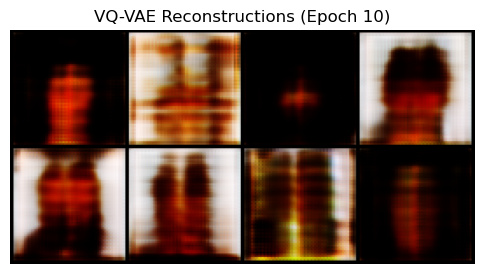

[VQ-VAE] Epoch 11/40 | Total: 16.8511 | Recon: 0.4603 | VQ: 16.3908 | Codes used: 192
[VQ-VAE] Epoch 12/40 | Total: 15.4709 | Recon: 0.4594 | VQ: 15.0115 | Codes used: 198
[VQ-VAE] Epoch 13/40 | Total: 14.2432 | Recon: 0.4584 | VQ: 13.7848 | Codes used: 198
[VQ-VAE] Epoch 14/40 | Total: 13.9154 | Recon: 0.4564 | VQ: 13.4591 | Codes used: 207
[VQ-VAE] Epoch 15/40 | Total: 14.0488 | Recon: 0.4555 | VQ: 13.5933 | Codes used: 225
[VQ-VAE] Epoch 16/40 | Total: 14.0501 | Recon: 0.4545 | VQ: 13.5956 | Codes used: 245
[VQ-VAE] Epoch 17/40 | Total: 13.5711 | Recon: 0.4542 | VQ: 13.1170 | Codes used: 249
[VQ-VAE] Epoch 18/40 | Total: 12.8770 | Recon: 0.4537 | VQ: 12.4234 | Codes used: 251
[VQ-VAE] Epoch 19/40 | Total: 12.6417 | Recon: 0.4526 | VQ: 12.1891 | Codes used: 252
[VQ-VAE] Epoch 20/40 | Total: 12.0322 | Recon: 0.4510 | VQ: 11.5812 | Codes used: 251


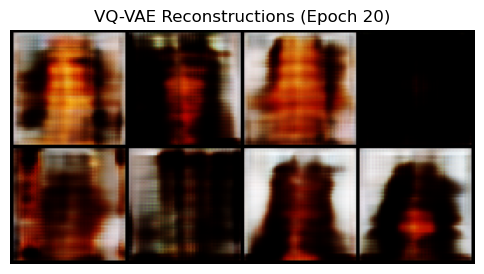

[VQ-VAE] Epoch 21/40 | Total: 12.0138 | Recon: 0.4501 | VQ: 11.5637 | Codes used: 251
[VQ-VAE] Epoch 22/40 | Total: 12.0860 | Recon: 0.4503 | VQ: 11.6356 | Codes used: 244
[VQ-VAE] Epoch 23/40 | Total: 11.8401 | Recon: 0.4499 | VQ: 11.3902 | Codes used: 251
[VQ-VAE] Epoch 24/40 | Total: 11.7820 | Recon: 0.4495 | VQ: 11.3326 | Codes used: 253
[VQ-VAE] Epoch 25/40 | Total: 11.9836 | Recon: 0.4493 | VQ: 11.5343 | Codes used: 248
[VQ-VAE] Epoch 26/40 | Total: 12.1912 | Recon: 0.4489 | VQ: 11.7423 | Codes used: 251
[VQ-VAE] Epoch 27/40 | Total: 11.8623 | Recon: 0.4490 | VQ: 11.4133 | Codes used: 248
[VQ-VAE] Epoch 28/40 | Total: 12.0755 | Recon: 0.4492 | VQ: 11.6263 | Codes used: 245
[VQ-VAE] Epoch 29/40 | Total: 12.3858 | Recon: 0.4493 | VQ: 11.9365 | Codes used: 238
[VQ-VAE] Epoch 30/40 | Total: 12.5675 | Recon: 0.4506 | VQ: 12.1169 | Codes used: 243


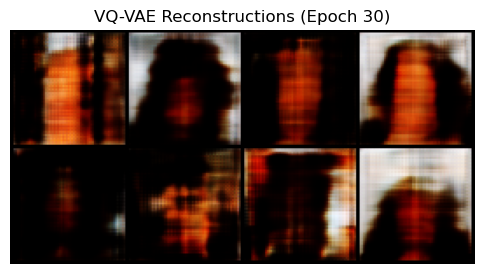

[VQ-VAE] Epoch 31/40 | Total: 12.2460 | Recon: 0.4506 | VQ: 11.7954 | Codes used: 240
[VQ-VAE] Epoch 32/40 | Total: 12.1227 | Recon: 0.4510 | VQ: 11.6716 | Codes used: 240
[VQ-VAE] Epoch 33/40 | Total: 11.5693 | Recon: 0.4506 | VQ: 11.1187 | Codes used: 245
[VQ-VAE] Epoch 34/40 | Total: 11.6064 | Recon: 0.4504 | VQ: 11.1560 | Codes used: 242
[VQ-VAE] Epoch 35/40 | Total: 11.6713 | Recon: 0.4499 | VQ: 11.2215 | Codes used: 236
[VQ-VAE] Epoch 36/40 | Total: 11.8243 | Recon: 0.4490 | VQ: 11.3753 | Codes used: 244
[VQ-VAE] Epoch 37/40 | Total: 11.8748 | Recon: 0.4481 | VQ: 11.4267 | Codes used: 242
[VQ-VAE] Epoch 38/40 | Total: 11.5641 | Recon: 0.4479 | VQ: 11.1163 | Codes used: 247
[VQ-VAE] Epoch 39/40 | Total: 11.6858 | Recon: 0.4472 | VQ: 11.2386 | Codes used: 243
[VQ-VAE] Epoch 40/40 | Total: 11.8309 | Recon: 0.4467 | VQ: 11.3842 | Codes used: 246


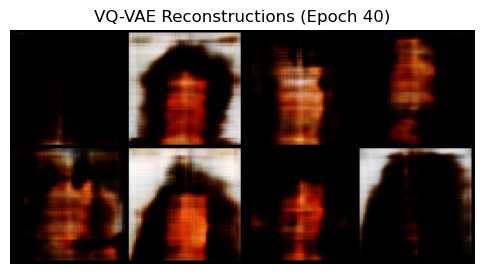


✅ VQ-VAE training complete and model saved



In [50]:
# ============================================================
# 3. Train VQ-VAE
# ============================================================

print("\n🔵 Starting VQ-VAE Training...\n")
train_vqvae(vqvae, dataloader)

# Save trained VQ-VAE
torch.save(vqvae.state_dict(), f"{SAVE_DIR}/vqvae.pth")
print("\n✅ VQ-VAE training complete and model saved\n")

In [51]:
# ============================================================
# 4. Extract Discrete Latent Maps
# ============================================================

print("🔵 Extracting discrete latent maps...\n")
latent_maps = extract_latents(vqvae, dataloader)

print("================================================")
print("Latent Maps Extracted")
print(f"Latent map shape : {latent_maps.shape}")
print("Each entry is a discrete index in [0, K-1]")
print("================================================")

🔵 Extracting discrete latent maps...

Latent Maps Extracted
Latent map shape : torch.Size([20000, 32, 32])
Each entry is a discrete index in [0, K-1]


In [52]:
# ============================================================
# 5. Initialize PixelCNN Prior
# ============================================================

pixelcnn = PixelCNN(CODEBOOK_SIZE).to(device)

print("================================================")
print("PixelCNN Prior Initialized")
print(f"Modeling p(z) over {CODEBOOK_SIZE} discrete codes")
print("================================================")

PixelCNN Prior Initialized
Modeling p(z) over 256 discrete codes


In [53]:
# ============================================================
# 6. Train PixelCNN
# ============================================================

print("\n🔵 Starting PixelCNN Training...\n")
train_pixelcnn(pixelcnn, latent_maps)

# Save trained PixelCNN
torch.save(pixelcnn.state_dict(), f"{SAVE_DIR}/pixelcnn.pth")
print("\n✅ PixelCNN training complete and model saved\n")


🔵 Starting PixelCNN Training...

[Masked PixelCNN] Epoch 1/30 | Loss: 2.2082
[Masked PixelCNN] Epoch 2/30 | Loss: 1.1677
[Masked PixelCNN] Epoch 3/30 | Loss: 1.0253
[Masked PixelCNN] Epoch 4/30 | Loss: 0.9785
[Masked PixelCNN] Epoch 5/30 | Loss: 0.9510
[Masked PixelCNN] Epoch 6/30 | Loss: 0.9313
[Masked PixelCNN] Epoch 7/30 | Loss: 0.9165
[Masked PixelCNN] Epoch 8/30 | Loss: 0.9037
[Masked PixelCNN] Epoch 9/30 | Loss: 0.8942
[Masked PixelCNN] Epoch 10/30 | Loss: 0.8858
[Masked PixelCNN] Epoch 11/30 | Loss: 0.8786
[Masked PixelCNN] Epoch 12/30 | Loss: 0.8727
[Masked PixelCNN] Epoch 13/30 | Loss: 0.8678
[Masked PixelCNN] Epoch 14/30 | Loss: 0.8637
[Masked PixelCNN] Epoch 15/30 | Loss: 0.8594
[Masked PixelCNN] Epoch 16/30 | Loss: 0.8552
[Masked PixelCNN] Epoch 17/30 | Loss: 0.8516
[Masked PixelCNN] Epoch 18/30 | Loss: 0.8484
[Masked PixelCNN] Epoch 19/30 | Loss: 0.8456
[Masked PixelCNN] Epoch 20/30 | Loss: 0.8431
[Masked PixelCNN] Epoch 21/30 | Loss: 0.8408
[Masked PixelCNN] Epoch 22/30 


🎨 Generating new face samples...



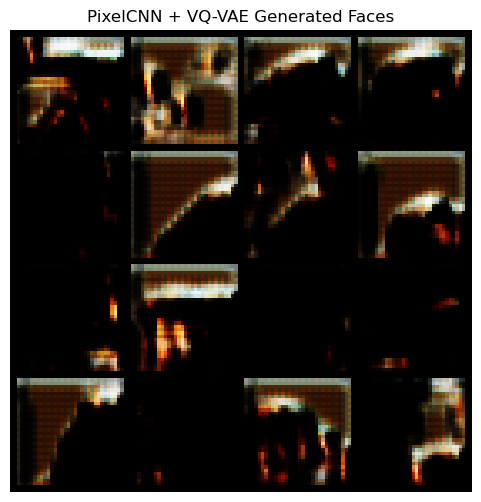

✅ Generated faces saved to: ./vqvae_results/generated_faces.png
Face generation complete
Saved to: ./vqvae_results/generated_faces.png


In [54]:
# ============================================================
# 7. Sample New Faces using PixelCNN + VQ-VAE
# ============================================================

print("\n🎨 Generating new face samples...\n")
generate_faces(vqvae, pixelcnn, n=16)

print("================================================")
print("Face generation complete")
print(f"Saved to: {SAVE_DIR}/generated_faces.png")
print("================================================")

## Part D: GAN for Face Generation [2 Marks]
Tasks
1. Train GAN on face dataset
2. Generate random face samples
3. Perform latent interpolation
4. Compare realism vs VAE-based models

In [4]:
class Generator(nn.Module):
    """
    Generator Network
    -----------------
    Purpose:
    - Takes a random latent vector z ~ N(0, I)
    - Upsamples it into a realistic face image (3x64x64)

    Key Idea:
    - Learns to map noise → data distribution
    - Uses ConvTranspose2d to progressively increase spatial resolution
    """

    def __init__(self, z_dim=100, img_channels=3, feature_maps=64):
        super().__init__()

        self.net = nn.Sequential(
            # Input: (batch_size, z_dim, 1, 1)
            # Output: (batch_size, 512, 4, 4)
            nn.ConvTranspose2d(z_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # ↑ Learns high-level global facial structure

            # Output: (batch_size, 256, 8, 8)
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # ↑ Adds coarse features like face shape and pose

            # Output: (batch_size, 128, 16, 16)
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # ↑ Learns mid-level features (eyes, nose placement)

            # Output: (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # ↑ Refines texture and local facial details

            # Output: (batch_size, 3, 64, 64)
            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # ↑ Tanh ensures output pixel values lie in [-1, 1]
        )

    def forward(self, z):
        # Forward pass maps latent noise to a fake face image
        return self.net(z)


In [5]:
class Discriminator(nn.Module):
    """
    Discriminator Network
    ---------------------
    Purpose:
    - Classifies an image as REAL or FAKE
    - Acts as a learned loss function for the generator

    Key Idea:
    - Uses strided convolutions to downsample
    - Learns hierarchical facial features
    """

    def __init__(self, img_channels=3, feature_maps=64):
        super().__init__()

        self.net = nn.Sequential(
            # Input: (batch_size, 3, 64, 64)
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # ↑ Captures low-level features (edges, colors)

            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ↑ Learns mid-level facial structures

            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ↑ Learns higher-level facial patterns

            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ↑ Aggregates global face information

            nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # ↑ Outputs probability of image being real
        )

    def forward(self, x):
        # Flatten output to shape (batch_size,)
        return self.net(x).view(-1)


In [7]:
z_dim = 100

generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

# Binary Cross Entropy is used since discriminator performs binary classification
criterion = nn.BCELoss()

# Adam optimizer with DCGAN-recommended hyperparameters
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [9]:
# ==========================================================
# Training
# ==========================================================

num_epochs = 30        # Typical for DCGAN on CelebA
batch_size = 128       # Should match DataLoader batch size
z_dim = 100            # Latent vector dimension

for epoch in range(num_epochs):
    for real_imgs, _ in dataloader:

        # Move real images to GPU/CPU
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Create real and fake labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # ======================================================
        # Step 1: Train Discriminator
        # ======================================================
        # Goal: Maximize log(D(x)) + log(1 - D(G(z)))

        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = generator(z)

        # Discriminator loss on real images
        loss_D_real = criterion(discriminator(real_imgs), real_labels)

        # Discriminator loss on fake images
        loss_D_fake = criterion(discriminator(fake_imgs.detach()), fake_labels)
        # detach() prevents gradients from flowing into the generator

        loss_D = loss_D_real + loss_D_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # ======================================================
        # Step 2: Train Generator
        # ======================================================
        # Goal: Fool the discriminator → maximize log(D(G(z)))

        loss_G = criterion(discriminator(fake_imgs), real_labels)
        # Generator wants fake images to be classified as real

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    # Logging training progress
    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Loss D: {loss_D.item():.4f} | "
        f"Loss G: {loss_G.item():.4f}"
    )


Epoch [1/30] | Loss D: 1.3767 | Loss G: 3.6711
Epoch [2/30] | Loss D: 0.7256 | Loss G: 2.5193
Epoch [3/30] | Loss D: 0.6832 | Loss G: 2.2062
Epoch [4/30] | Loss D: 0.6654 | Loss G: 3.1746
Epoch [5/30] | Loss D: 0.8273 | Loss G: 4.7816
Epoch [6/30] | Loss D: 0.8373 | Loss G: 4.0713
Epoch [7/30] | Loss D: 0.7761 | Loss G: 1.4045
Epoch [8/30] | Loss D: 0.7883 | Loss G: 2.0278
Epoch [9/30] | Loss D: 3.6428 | Loss G: 5.5907
Epoch [10/30] | Loss D: 0.5472 | Loss G: 1.9283
Epoch [11/30] | Loss D: 0.9496 | Loss G: 6.4886
Epoch [12/30] | Loss D: 1.3313 | Loss G: 0.2874
Epoch [13/30] | Loss D: 0.8437 | Loss G: 1.3673
Epoch [14/30] | Loss D: 0.2755 | Loss G: 3.3554
Epoch [15/30] | Loss D: 0.4330 | Loss G: 3.8450
Epoch [16/30] | Loss D: 0.7710 | Loss G: 3.5534
Epoch [17/30] | Loss D: 0.4607 | Loss G: 1.6438
Epoch [18/30] | Loss D: 0.6518 | Loss G: 6.3465
Epoch [19/30] | Loss D: 0.4947 | Loss G: 2.1259
Epoch [20/30] | Loss D: 0.4312 | Loss G: 4.1097
Epoch [21/30] | Loss D: 0.6675 | Loss G: 3.1334
E

(-0.5, 529.5, 529.5, -0.5)

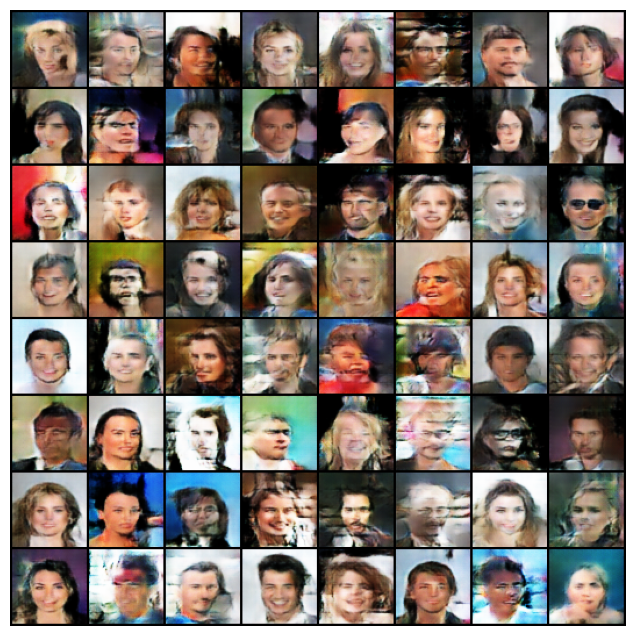

In [15]:
import torchvision
generator.eval()  # Disable BatchNorm updates
with torch.no_grad():
    # Sample random latent vectors
    z = torch.randn(64, z_dim, 1, 1, device=device)

    # Generate fake faces
    fake_faces = generator(z)

# Visualize generated images in a grid
grid = torchvision.utils.make_grid(fake_faces, normalize=True, nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")


(-0.5, 661.5, 67.5, -0.5)

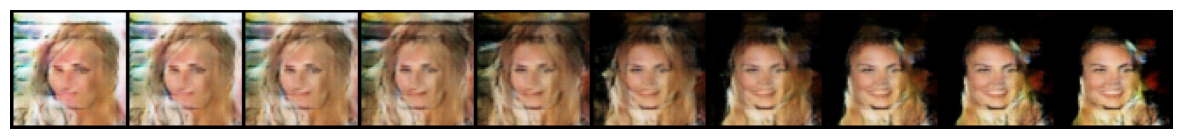

In [17]:
def interpolate(z1, z2, steps=10):
    """
    Linearly interpolates between two latent vectors.
    Used to verify continuity of the GAN latent space.
    """
    return [(1 - t) * z1 + t * z2 for t in torch.linspace(0, 1, steps)]

# Sample two random latent vectors
z_start = torch.randn(1, z_dim, 1, 1, device=device)
z_end = torch.randn(1, z_dim, 1, 1, device=device)

# Generate interpolated latent vectors
z_interp = interpolate(z_start, z_end, steps=10)

# Generate corresponding images
images = [generator(z).squeeze(0) for z in z_interp]

# Visualize interpolation
grid = torchvision.utils.make_grid(images, normalize=True, nrow=10)
plt.figure(figsize=(15, 3))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")


## Part E: Comparative Analysis [1 Mark]
Include visual examples.